In [42]:
import transformer_lens as tl
import torch as t
import torch.nn.functional as F
from acdc.TLACDCExperiment import TLACDCCorrespondence
import dataclasses as dc
from typing import Optional
from enum import Enum
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import random

flatten = itertools.chain.from_iterable

In [43]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = tl.HookedTransformer.from_pretrained("attn-only-2l")
model = model.to(device)

# NOTE. The following lines are present in the code of the official repo,
# but I don't know what it really does.

model.set_use_attn_result(True)     
model.set_use_split_qkv_input(True)

Loaded pretrained model attn-only-2l into HookedTransformer
Moving model to device:  cpu


In [44]:
for name, parameters in model.named_parameters():
    print(f"{name}: {parameters.shape}")

embed.W_E: torch.Size([48262, 512])
pos_embed.W_pos: torch.Size([1024, 512])
blocks.0.attn.W_Q: torch.Size([8, 512, 64])
blocks.0.attn.W_O: torch.Size([8, 64, 512])
blocks.0.attn.b_Q: torch.Size([8, 64])
blocks.0.attn.b_O: torch.Size([512])
blocks.0.attn.W_K: torch.Size([8, 512, 64])
blocks.0.attn.W_V: torch.Size([8, 512, 64])
blocks.0.attn.b_K: torch.Size([8, 64])
blocks.0.attn.b_V: torch.Size([8, 64])
blocks.1.attn.W_Q: torch.Size([8, 512, 64])
blocks.1.attn.W_O: torch.Size([8, 64, 512])
blocks.1.attn.b_Q: torch.Size([8, 64])
blocks.1.attn.b_O: torch.Size([512])
blocks.1.attn.W_K: torch.Size([8, 512, 64])
blocks.1.attn.W_V: torch.Size([8, 512, 64])
blocks.1.attn.b_K: torch.Size([8, 64])
blocks.1.attn.b_V: torch.Size([8, 64])
unembed.W_U: torch.Size([512, 48262])
unembed.b_U: torch.Size([48262])


In [45]:
# NOTE. Edges from the ACDC package, maybe we should create a method to compare our graph to theirs.

correspondence = TLACDCCorrespondence.setup_from_model(model)
correspondence.edges


In [46]:
# NOTE. I got this code from ARENA.

def generate_repeated_tokens(
    model: tl.HookedTransformer,
    seq_len: int,
    num_seq: int = 1
) -> t.Tensor:
    prefix = (t.ones(num_seq, 1) * model.tokenizer.bos_token_id).long()
    rep_tokens_half = t.randint(0, model.cfg.d_vocab, (num_seq, seq_len), dtype=t.int64)
    rep_tokens = t.cat([prefix, rep_tokens_half, rep_tokens_half], dim=-1).to(device)
    return rep_tokens

seq_len = 5
num_seq = 100

dataset = generate_repeated_tokens(model=model, seq_len=seq_len, num_seq=num_seq)[:, :-1]
dataset.shape


torch.Size([100, 10])

In [47]:
logits, cache = model.run_with_cache(dataset)
for name, values in cache.items():
    print(f"{name}: {values.shape}")

hook_embed: torch.Size([100, 10, 512])
hook_pos_embed: torch.Size([100, 10, 512])
blocks.0.hook_resid_pre: torch.Size([100, 10, 512])
blocks.0.hook_q_input: torch.Size([100, 10, 8, 512])
blocks.0.hook_k_input: torch.Size([100, 10, 8, 512])
blocks.0.hook_v_input: torch.Size([100, 10, 8, 512])
blocks.0.ln1.hook_scale: torch.Size([100, 10, 8, 1])
blocks.0.ln1.hook_normalized: torch.Size([100, 10, 8, 512])
blocks.0.attn.hook_q: torch.Size([100, 10, 8, 64])
blocks.0.attn.hook_k: torch.Size([100, 10, 8, 64])
blocks.0.attn.hook_v: torch.Size([100, 10, 8, 64])
blocks.0.attn.hook_attn_scores: torch.Size([100, 8, 10, 10])
blocks.0.attn.hook_pattern: torch.Size([100, 8, 10, 10])
blocks.0.attn.hook_z: torch.Size([100, 10, 8, 64])
blocks.0.attn.hook_result: torch.Size([100, 10, 8, 512])
blocks.0.hook_attn_out: torch.Size([100, 10, 512])
blocks.0.hook_resid_post: torch.Size([100, 10, 512])
blocks.1.hook_resid_pre: torch.Size([100, 10, 512])
blocks.1.hook_q_input: torch.Size([100, 10, 8, 512])
blocks

In [48]:
@dc.dataclass(frozen=True)
class TransformerNode:
    hook_name: str
    head_idx: Optional[int] = None

    @property
    def index(self):
        colon = slice(None)
        head_idx = self.head_idx

        if head_idx is not None: return tuple([colon, colon, head_idx, colon])
        else: return tuple([colon, colon, colon])
    
    def __repr__(self):
        head_idx = self.head_idx
        return f"N({self.hook_name}{f'({head_idx})' if head_idx is not None else ''})"

class TransformerEdgeType(Enum):
    ADDITION = 0
    DIRECT_COMPUTATION = 1
    PLACEHOLDER = 2

    def __repr__(self):
        return self.name

def setup_nx_graph_from_model(model: tl.HookedTransformer):
    graph = nx.DiGraph()
    
    n_layers = model.cfg.n_layers
    residual_stream_nodes: list[TransformerNode] = []

    logits_node = TransformerNode(f"blocks.{n_layers-1}.hook_resid_post")

    graph.add_node(logits_node, incoming_edge_type=TransformerEdgeType.ADDITION, subset="logits")
    residual_stream_nodes.append(logits_node)

    for layer_idx in range(model.cfg.n_layers - 1, -1, -1):
        new_residual_stream_nodes: list[TransformerNode] = []

        for head_idx in range(model.cfg.n_heads - 1, -1, -1):
            cur_head_node = TransformerNode(f"blocks.{layer_idx}.attn.hook_result", head_idx)
            graph.add_node(cur_head_node, incoming_edge_type=TransformerEdgeType.PLACEHOLDER, subset=f"layer {layer_idx} result")
    
            for residual_stream_node in residual_stream_nodes:
                graph.add_edge(
                    cur_head_node, residual_stream_node,
                    edge_type=TransformerEdgeType.ADDITION,
                )

            for letter in "qkv":
                letter_hook_node = TransformerNode(f"blocks.{layer_idx}.attn.hook_{letter}", head_idx)
                graph.add_node(letter_hook_node, incoming_edge_type=TransformerEdgeType.DIRECT_COMPUTATION, subset=f"layer {layer_idx} letter")

                letter_input_hook_node = TransformerNode(f"blocks.{layer_idx}.hook_{letter}_input", head_idx)
                graph.add_node(letter_input_hook_node, incoming_edge_type=TransformerEdgeType.ADDITION, subset=f"layer {layer_idx} input")

                graph.add_edge(
                    letter_hook_node, cur_head_node,
                    edge_type=TransformerEdgeType.PLACEHOLDER,
                )

                graph.add_edge(
                    letter_input_hook_node, letter_hook_node,
                    edge_type=TransformerEdgeType.DIRECT_COMPUTATION,
                )

                new_residual_stream_nodes.append(letter_input_hook_node)

        residual_stream_nodes.extend(new_residual_stream_nodes)

    token_embed_node = TransformerNode(hook_name="hook_embed")
    pos_embed_node = TransformerNode("hook_pos_embed")

    # NOTE. For now, we will always include the positional embedding node. 

    embed_nodes = [token_embed_node, pos_embed_node]

    for embed_node in embed_nodes:
        graph.add_node(embed_node, incoming_edge_type=TransformerEdgeType.PLACEHOLDER, subset="embed")

        for residual_stream_node in residual_stream_nodes:
            graph.add_edge(
                embed_node, residual_stream_node,
                edge_type=TransformerEdgeType.ADDITION
            )

    for u, v, data in graph.edges.data():
        data["present"] = True
        v = graph.nodes[v]
        assert data["edge_type"] == v["incoming_edge_type"]

    return graph


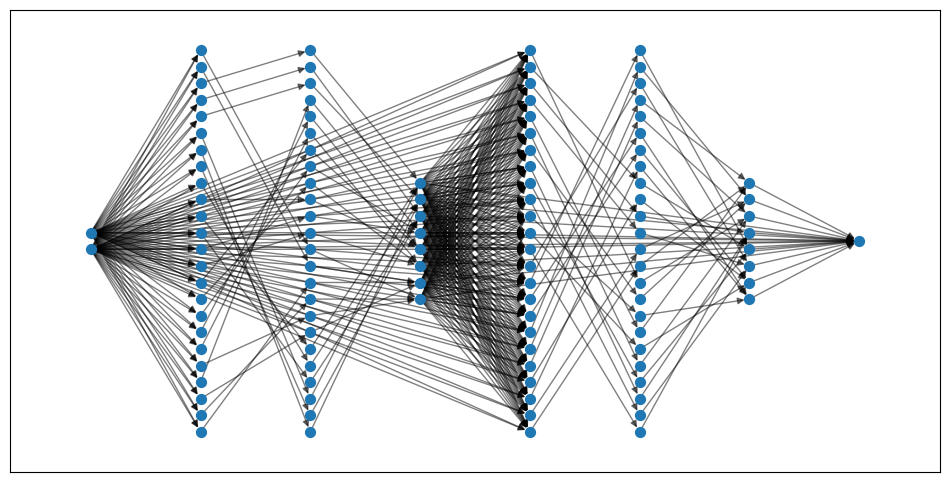

In [49]:
graph = setup_nx_graph_from_model(model)

plt.figure(figsize=(12, 6))
pos = nx.multipartite_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=50)
nx.draw_networkx_edges(graph, pos, node_size=50, alpha=0.5)
plt.show()


In [50]:
# Setup corrupted and online cache

model.reset_hooks()

model.add_hook(
    name = lambda hook_name: any([substring in hook_name for substring in ["hook_result", "hook_pos_embed", "hook_embed"]]),
    hook = lambda z, hook: t.zeros_like(z))

_, corrupted_cache = model.run_with_cache(dataset)
online_cache = dict()

model.reset_hooks()

In [51]:
def receiver_hook(hook_tensor, hook):
    hook_nodes = [node for node in graph.nodes if node.hook_name == hook.name]
    incoming_edge_types = [graph.nodes[node]['incoming_edge_type'] for node in hook_nodes]
    
    if TransformerEdgeType.DIRECT_COMPUTATION in incoming_edge_types:
        assert incoming_edge_types == [TransformerEdgeType.DIRECT_COMPUTATION for _ in incoming_edge_types], f"All incoming edges should be the same type not {incoming_edge_types}"
    
        old_z = hook_tensor.clone()
        hook_tensor[:] = corrupted_cache[hook.name]
    
        for receiver in hook_nodes:
            senders = [sender for sender, _, data in graph.in_edges(receiver, data=True) if data["present"]]

            assert len(senders) <= 1, "This is a direct computation, so there should only be one sender node"
            if len(senders) == 0: continue

            hook_tensor[receiver.index] = old_z[receiver.index]
    
    if TransformerEdgeType.ADDITION in incoming_edge_types:
        assert incoming_edge_types == [TransformerEdgeType.ADDITION for _ in incoming_edge_types], f"All incoming edges should be the same type, not {incoming_edge_types}"
        hook_tensor[:] = corrupted_cache[hook.name]
        
        for receiver in hook_nodes:
            for sender, _, data in graph.in_edges(receiver, data=True):
                if not data["present"]: continue

                assert data["edge_type"] == TransformerEdgeType.ADDITION
            
                hook_tensor[receiver.index] += online_cache[sender.hook_name][sender.index]
                hook_tensor[receiver.index] -= corrupted_cache[sender.hook_name][sender.index]

    return hook_tensor

def sender_hook(hook_tensor, hook):
    online_cache[hook.name] = hook_tensor
    return hook_tensor
    

In [52]:
model.reset_hooks()
receiver_hook_names = set([
    node.hook_name
    for node, data in graph.nodes(data=True)
    if data["incoming_edge_type"] != TransformerEdgeType.PLACEHOLDER])

for hook_name in receiver_hook_names:
    model.add_hook(
        name=hook_name,
        hook=receiver_hook)

sender_hook_names = set(flatten([
    [sender.hook_name, receiver.hook_name]
    for sender, receiver, data
    in graph.edges(data=True)
    if data["edge_type"] != TransformerEdgeType.PLACEHOLDER]))

for hook_name in sender_hook_names:
    model.add_hook(
        name=hook_name,
        hook=sender_hook)


In [53]:
logits, cache = model.run_with_cache(dataset)

# NOTE. Ratio of sequences that have the associated argmax logit as the correct one.
(dataset[:, seq_len] == logits[:, -1, :].argmax(-1)).float().mean().item()


0.49000000953674316

In [54]:
# NOTE. Just a test, removing random edges.
for sender, receiver, data in graph.edges(data=True):
    data["present"] = True

    if random.random() < 0.01:
        data["present"] = False

logits, cache = model.run_with_cache(dataset)

(dataset[:, seq_len] == logits[:, -1, :].argmax(-1)).float().mean().item()


0.0

In [55]:
def kl_divergence(logits, logits_corrupted):
    probs = F.softmax(logits, dim=-1)
    probs_corrupted = F.softmax(logits_corrupted, dim=-1)
    kl_div = F.kl_div(probs.log(), probs_corrupted, reduction='batchmean')
    return kl_div.item()

In [56]:
def pruning(graph, model, dataset, corrupted_cache, online_cache, threshold=0.01):
    model.reset_hooks()

    for receiver in graph.nodes():
        if graph.nodes[receiver]['incoming_edge_type'] == TransformerEdgeType.PLACEHOLDER:
            continue
        
        # Temporarily remove each incoming edge
        for sender, _, data in graph.in_edges(receiver, data=True):
            if data["present"]:
                data["present"] = False
                
                _, corrupted_cache = model.run_with_cache(dataset)
                kl_div = kl_divergence(online_cache[receiver.hook_name], corrupted_cache[receiver.hook_name])
                
                if kl_div < threshold:
                    print(f"Pruned edge from {sender} to {receiver} with KL divergence {kl_div}")
                    data["present"] = False
                else:
                    print(f"Kept edge from {sender} to {receiver} with KL divergence {kl_div}")
                    data["present"] = True
    return graph

In [57]:
def ACDC(graph, model, dataset, corrupted_cache, online_cache, threshold=0.01):
    pruning(graph, model, dataset, corrupted_cache, online_cache, threshold)
    
    receiver_hook_names = set([
        node.hook_name
        for node, data in graph.nodes(data=True)
        if data["incoming_edge_type"] != TransformerEdgeType.PLACEHOLDER])
    
    for hook_name in receiver_hook_names:
        model.add_hook(
            name=hook_name,
            hook=receiver_hook)

    sender_hook_names = set(flatten([
        [sender.hook_name, receiver.hook_name]
        for sender, receiver, data
        in graph.edges(data=True)
        if data["edge_type"] != TransformerEdgeType.PLACEHOLDER]))

    for hook_name in sender_hook_names:
        model.add_hook(
            name=hook_name,
            hook=sender_hook)
        
    # update the graph removing all the edges that were pruned
    to_remove = []
    for sender, receiver, data in graph.edges(data=True):
        if not data["present"]:
            to_remove.append((sender, receiver))
            
    for node in to_remove:
        graph.remove_edge(node[0], node[1])     

    return graph


In [58]:
graph = ACDC(graph, model, dataset, corrupted_cache, online_cache, threshold=0.01)

Kept edge from N(blocks.1.attn.hook_result(7)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(6)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(5)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(4)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(3)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(2)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(1)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.1.attn.hook_result(0)) to N(blocks.1.hook_resid_post) with KL divergence 8.16929817199707
Kept edge from N(blocks.0.attn.hook_result(7)) to N(blocks.1.hook_resid_post) with KL di

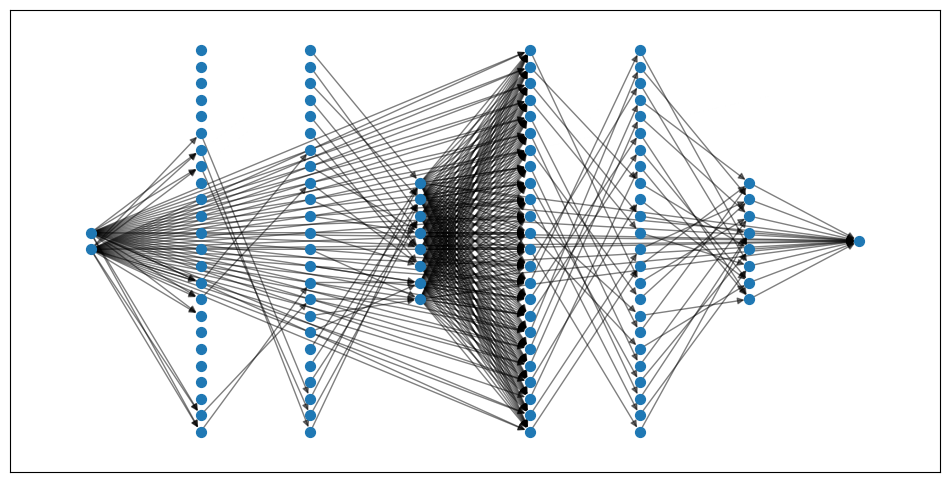

In [60]:
plt.figure(figsize=(12, 6))
pos = nx.multipartite_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=50)
nx.draw_networkx_edges(graph, pos, node_size=50, alpha=0.5)
plt.show()